## Untuk menguji coba versi keras yang digunakan

In [219]:
from keras import __version__ as v
from keras import backend as K
import keras

print('Menggunakan Keras Versi ' + str(v))
print('Backend ' + str(K.backend().title()))

Menggunakan Keras Versi 2.0.2
Backend Tensorflow


## Menggunakan MNIST dengan variasi layer konvolusi

MNIST adalah dataset angka dari 0 hingga 9 yang dikenal sebagai "Hello World" untuk *image processing*. Terdiri dari 60000 training example dan 10000 testing example. Dataset terdiri dari x berupa gambar dan y label dari gambar tersebut. Dataset secara resmi dapat di download di http://yann.lecun.com/exdb/mnist/.

In [220]:
from keras.datasets import mnist
(trainData, trainLabels), (testData, testLabels) = mnist.load_data()

## Konfigurasi Umum

In the neural network terminology:

* one **epoch** = one forward pass and one backward pass of all the training examples. Nilai epochs yang kecil akan membuat hasil underfitting, ketika terlalu besar maka hanya mengingat dari dataset training saja.
* **batch size** = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need. Typically networks trains faster with mini-batches. That's because we update weights after each propagation.  If we used all samples during propagation we would make only 1 update for the network's parameter.
* **number of iterations** = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).

Example: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

* **num_classes** merupakan banyaknya kelas yang diprediksi. Nilainya berdasarkan keluaran dari *inner product*.

* **img_rows, img_cols** merupakan width dan height dari dataset yang digunakan.

In [221]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

## Konfigurasi Dataset
Dataset MNIST dilakukan penyesuaian dimana ukuran dirubah berdasarkan *image dimensions* yang telah kita tentukan sebelumnya. Angka 1 mengindikasikan gambar hanya tersedia dalam 1 channel atau grayscale.

**Nb**: Penulisan channel untuk tensorflow berada di belakang.

Selanjutnya, perubahan nilai grayscale menggunakan skala 0-1 dari sebelumnya 0-255. Karena sekarang menggunakan python2, agar mendapatkan nilai float maka harus dibagi dengan nilai float juga.

In [222]:
if K.image_data_format() == 'channels_first': # Theano
    trainData = trainData.reshape(trainData.shape[0], 1, img_rows, img_cols)
    testData = testData.reshape(testData.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else: # Tensorflow
    trainData = trainData.reshape(trainData.shape[0], img_rows, img_cols, 1)
    testData = testData.reshape(testData.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

trainData = trainData.astype('float32')
testData = testData.astype('float32')
trainData /= 255.0 # Merubah scaling 0 - 255 menjadi 0 - 1.0
testData /= 255.0

print('trainData shape:', trainData.shape)
print(trainData.shape[0], 'train samples')
print(testData.shape[0], 'test samples')

# convert class vectors to binary class matrices
trainLabels = keras.utils.to_categorical(trainLabels, num_classes)
testLabels = keras.utils.to_categorical(testLabels, num_classes)

('trainData shape:', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')


## Struktur data sekuensial dengan **model**
The core data structure of Keras is a model, a way to organize layers. The simplest type of model is the Sequential model, a linear stack of layers. For more complex architectures, you should use the [Keras functional API](http://keras.io/getting-started/functional-api-guide), which allows to build arbitrary graphs of layers.

In [223]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

## Beberapa opsi untuk layer

### *[Core Layer](https://keras.io/layers/core/)*

#### Dense (Fully connected / inner product)
Untuk menggabungkan semua neuron dan melakukan klasifikasi (pada layer terakhir). Output merupakan banyaknya kelas yang dapat di klasifikasi.

*keras.layers.core.Dense(**units**, **activation**=None, **use_bias**=True, **kernel_initializer**='glorot_uniform', **bias_initializer**='zeros', **kernel_regularizer**=None, **bias_regularizer**=None, **activity_regularizer**=None, **kernel_constraint**=None, **bias_constraint**=None)*

#### Dropout
Mencegah overfitting berdasarkan rate yang diberikan.

*keras.layers.core.Dropout(**rate**, **noise_shape**=None, **seed**=None)*

#### Flatten
Untuk menggabungkan image shape menjadi vector (matriks 1 dimensi).

*keras.layers.core.Flatten()*


### *[Convolution Layer](https://keras.io/layers/convolutional)*

#### Conv2D
Konvolusi untuk matriks 2D seperti gambar. Opsi yang harus ditentukan adalah filters (output) dan kernel_size (dan input_shape jika menjadi layer pertama).

*keras.layers.convolutional.Conv2D(**filters**, **kernel_size**, **strides**=(1, 1), **padding**='valid', **data_format**=None, **dilation_rate**=(1, 1), **activation**=None, **use_bias**=True, **kernel_initializer**='glorot_uniform', **bias_initializer**='zeros', **kernel_regularizer**=None, **bias_regularizer**=None, **activity_regularizer**=None, **kernel_constraint**=None, **bias_constraint**=None)*

### *[Pooling Layer](https://keras.io/layers/pooling)*

#### MaxPooling2D
Pooling untuk matriks 2D

*keras.layers.pooling.MaxPooling2D(**pool_size**=(2, 2), **strides**=None, **padding**='valid', **data_format**=None)*

---
**Nb**: [Apa bedanya **strides** dan **padding**]( https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/)

## Konfigurasi model

Once your model looks good, configure its learning process with **.compile()**. 

*compile(self, **optimizer**, **loss**, **metrics**=None, **sample_weight_mode**=None)*

Argumen yang diberikan adalah [loss](https://keras.io/losses/) dan [optimizer](https://keras.io/optimizers/)

Kita juga bisa melihat rangkuman dari model yang kita buat dengan **.summary()**.

In [224]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Compile dengan konfigurasi lebih banyak
# model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

### Learning

Learning dilakukan dengan **.fit()**

*fit(self, **x**, **y**, **batch_size**=32, **epochs**=10, **verbose**=1, **callbacks**=None, **validation_split**=0.0, **validation_data**=None, **shuffle**=True, **class_weight**=None, **sample_weight**=None, **initial_epoch**=0)*

Untuk mengujinya, bisa dengan **.evaluate**

In [225]:
model.fit(trainData, trainLabels,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(testData, testLabels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 4s - loss: 0.3252 - acc: 0.9033 - val_loss: 0.0731 - val_acc: 0.9769
Epoch 2/12
60000/60000 [==============================] - 4s - loss: 0.1094 - acc: 0.9678 - val_loss: 0.0526 - val_acc: 0.9826
Epoch 3/12
60000/60000 [==============================] - 4s - loss: 0.0839 - acc: 0.9754 - val_loss: 0.0427 - val_acc: 0.9861
Epoch 4/12
60000/60000 [==============================] - 4s - loss: 0.0697 - acc: 0.9792 - val_loss: 0.0391 - val_acc: 0.9868
Epoch 5/12
60000/60000 [==============================] - 4s - loss: 0.0616 - acc: 0.9823 - val_loss: 0.0368 - val_acc: 0.9877
Epoch 6/12
60000/60000 [==============================] - 4s - loss: 0.0549 - acc: 0.9838 - val_loss: 0.0355 - val_acc: 0.9876
Epoch 7/12
60000/60000 [==============================] - 4s - loss: 0.0499 - acc: 0.9858 - val_loss: 0.0330 - val_acc: 0.9881
Epoch 8/12
60000/60000 [==============================] - 4s 

In [226]:
(loss, accuracy) = model.evaluate(testData, testLabels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

('Test loss:', 0.02764159694814225)
('Test accuracy:', 0.99080000000000001)


### Predicting

In [227]:
import numpy as np
import matplotlib.pyplot as plt
import keras.preprocessing.image as image

In [228]:
def display_examples():
    for i in np.random.choice(np.arange(0, len(testLabels)), size=(10,)):
        # classify the digit
        probs = model.predict(testData[np.newaxis, i])
        print(probs)
        prediction = probs.argmax(axis=1)

        # resize the image from a 28 x 28 image to a 96 x 96 image so we
        # can better see it
        img = image.array_to_img(testData[i] * 255)
        plt.imshow(img)
        plt.show()
        # show the image and prediction
        print("[INFO] Predicted:" + str(prediction[0]) + ", Actual: " + str(np.argmax(testLabels[i])))

[[  9.60934532e-09   9.99988198e-01   5.18609852e-07   8.67707850e-10
    4.19716571e-06   4.99937469e-09   5.04266389e-08   6.77969592e-06
    5.63296076e-08   1.65949828e-07]]


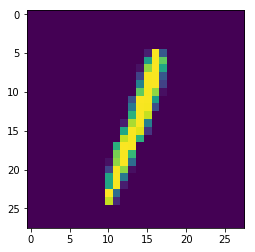

[INFO] Predicted:1, Actual: 1
[[  3.85256769e-08   9.99985218e-01   3.95165614e-07   6.20586249e-09
    6.34820117e-06   1.28820581e-08   1.77658990e-08   6.46613398e-06
    9.03904095e-07   6.94637379e-07]]


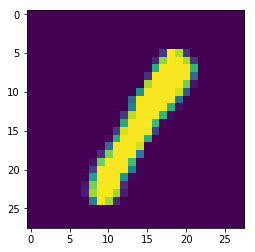

[INFO] Predicted:1, Actual: 1
[[  3.03173394e-13   1.04179589e-15   1.25826761e-14   7.75350884e-07
    1.35694109e-13   9.99999046e-01   1.75493356e-10   1.35161294e-12
    2.44897294e-08   5.51667760e-08]]


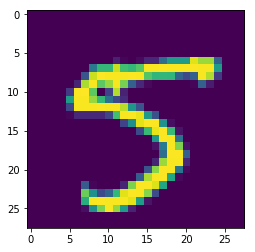

[INFO] Predicted:5, Actual: 5
[[  6.47903398e-11   5.01325559e-09   8.80282229e-08   1.09885427e-07
    6.17526724e-11   1.05754207e-11   3.64993322e-12   9.99999046e-01
    1.18732288e-10   7.71418968e-07]]


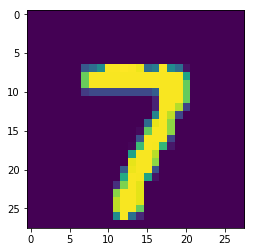

[INFO] Predicted:7, Actual: 7
[[  3.79313203e-09   5.25105179e-07   1.45746037e-06   9.99958038e-01
    6.55701982e-09   4.58925479e-06   3.28852723e-10   2.50731034e-07
    8.01545141e-08   3.51405761e-05]]


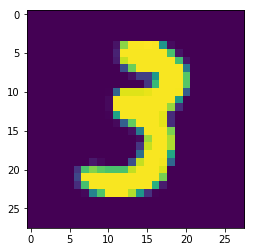

[INFO] Predicted:3, Actual: 3
[[  5.02173173e-12   9.21586751e-10   3.55061691e-09   9.99999881e-01
    1.11019111e-11   5.42820260e-08   1.96453739e-11   3.13105026e-08
    7.00714542e-10   1.39689050e-07]]


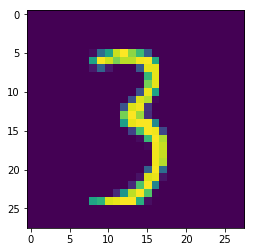

[INFO] Predicted:3, Actual: 3
[[  1.74326731e-09   1.87026092e-08   6.15190656e-05   1.30185288e-06
    8.93919661e-11   1.25064837e-11   4.05937228e-11   9.99933839e-01
    5.66185534e-08   3.26855047e-06]]


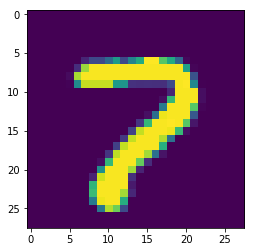

[INFO] Predicted:7, Actual: 7
[[  2.34494428e-06   5.41875750e-07   1.79204671e-05   5.25909945e-06
    1.24474282e-05   2.87271587e-06   1.28809745e-06   9.96642351e-01
    4.43224565e-07   3.31457565e-03]]


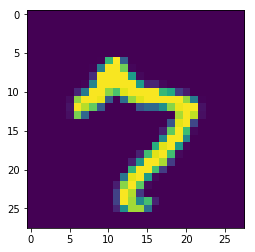

[INFO] Predicted:7, Actual: 7
[[  2.17790475e-09   1.51140073e-10   1.63908279e-11   1.24946418e-12
    1.05549162e-07   4.78294175e-11   9.99999881e-01   1.57930212e-12
    5.19504145e-12   1.46348871e-11]]


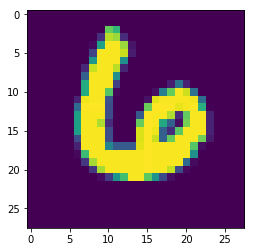

[INFO] Predicted:6, Actual: 6
[[  6.30098862e-09   2.59756359e-08   9.99877453e-01   3.74514570e-08
    6.08957162e-10   2.08391073e-12   8.45282455e-10   1.22408965e-04
    8.07521587e-08   2.47953658e-10]]


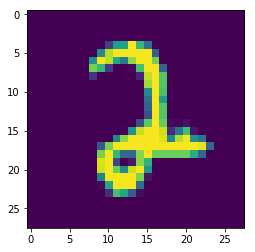

[INFO] Predicted:2, Actual: 2


In [229]:
display_examples()

In [230]:
model.get_config()
# Less info
# model.layers[0].get_config

[{'class_name': 'Conv2D',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'batch_input_shape': (None, 28, 28, 1),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'data_format': 'channels_last',
   'dilation_rate': (1, 1),
   'dtype': 'float32',
   'filters': 32,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'kernel_size': (3, 3),
   'name': 'conv2d_3',
   'padding': 'valid',
   'strides': (1, 1),
   'trainable': True,
   'use_bias': True}},
 {'class_name': 'Conv2D',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'data_format': 'channels_last',
   'dilation_rate': (1, 1),

In [231]:
model.count_params()
# less info
# model.layers[0].count_params()

1199882

In [232]:
weights, biases = model.layers[0].get_weights()
model.layers[0].get_weights()

[array([[[[-0.07261078, -0.04458132,  0.1758206 ,  0.06265823, -0.22824368,
            0.03892979,  0.08272105, -0.06003016, -0.0276896 , -0.23640285,
            0.13766137, -0.23898184, -0.36164185, -0.25695243,  0.17748596,
            0.07549589,  0.08937632,  0.12962255,  0.05279873,  0.02290714,
           -0.01689927, -0.05539704,  0.23939583,  0.07331841,  0.23205115,
            0.18042225,  0.25593838, -0.21893094, -0.07023896,  0.13733898,
            0.03856466,  0.00358085]],
 
         [[ 0.21018308, -0.00982529, -0.01191717,  0.12752506, -0.24543396,
            0.1488962 ,  0.12761326,  0.10597499, -0.0084203 , -0.1622503 ,
            0.12715191, -0.1483461 , -0.20861487, -0.28993502,  0.09891094,
           -0.17844343,  0.06097199,  0.1429403 ,  0.11856847,  0.1996353 ,
            0.17841712,  0.06041485,  0.05396669,  0.07146737,  0.08135359,
            0.15458581,  0.26093268,  0.02213987, -0.32529548,  0.11299111,
           -0.08679061, -0.21806064]],
 
      

In [233]:
def plot_filters(layer):
    import matplotlib
    filters = layer.get_weights()[0]

    for j in range(len(filters)):
        for k in range(len(filters)):
#             for l in range(len(filters[j][k])):
            print(len(filters[j][k][0]))
            fig = plt.subplot()
            fig.matshow(filters[j][k], cmap = matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
            plt.tight_layout()
            print('\nDisplaying Data ' + str(j) + ',' + str(k))
            plt.show()
            print(filters[j][k])

32

Displaying Data 0,0


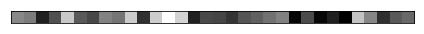

[[-0.07261078 -0.04458132  0.1758206   0.06265823 -0.22824368  0.03892979
   0.08272105 -0.06003016 -0.0276896  -0.23640285  0.13766137 -0.23898184
  -0.36164185 -0.25695243  0.17748596  0.07549589  0.08937632  0.12962255
   0.05279873  0.02290714 -0.01689927 -0.05539704  0.23939583  0.07331841
   0.23205115  0.18042225  0.25593838 -0.21893094 -0.07023896  0.13733898
   0.03856466  0.00358085]]
32

Displaying Data 0,1


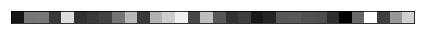

[[ 0.21018308 -0.00982529 -0.01191717  0.12752506 -0.24543396  0.1488962
   0.12761326  0.10597499 -0.0084203  -0.1622503   0.12715191 -0.1483461
  -0.20861487 -0.28993502  0.09891094 -0.17844343  0.06097199  0.1429403
   0.11856847  0.1996353   0.17841712  0.06041485  0.05396669  0.07146737
   0.08135359  0.15458581  0.26093268  0.02213987 -0.32529548  0.11299111
  -0.08679061 -0.21806064]]
32

Displaying Data 0,2


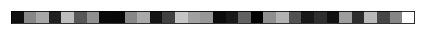

[[ 0.22208875 -0.02140025 -0.08701432  0.18709579 -0.13284869  0.07559419
  -0.0400365   0.23268779  0.23454446 -0.02353762 -0.09084342  0.21332242
   0.12156773 -0.14975041 -0.07492615 -0.05504121  0.22938769  0.2032702
   0.05341584  0.25456256 -0.03739526 -0.11023662  0.08450241  0.20521627
   0.15698384  0.21785142 -0.06694257  0.16141608 -0.12470245  0.1108964
  -0.01944522 -0.26747131]]
32

Displaying Data 1,0


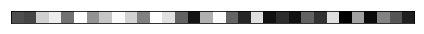

[[ 0.11750008  0.13153952 -0.10321517 -0.15171435  0.05387326 -0.18191668
  -0.00079725 -0.08535119 -0.17472114 -0.10759735  0.03063936 -0.18336576
  -0.13123906  0.08180314  0.21442987 -0.04934596 -0.17352307  0.08045075
   0.18538609 -0.12796809  0.21835312  0.1749811   0.22185557  0.08103814
   0.16279769 -0.12801835  0.2497692  -0.02320858  0.23067582  0.02512109
   0.10550269  0.19649202]]
32

Displaying Data 1,1


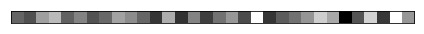

[[ 0.10461108  0.14595951 -0.0069729  -0.05965091  0.11090972  0.0481966
   0.13933538  0.09890107 -0.01327787  0.02994611  0.10431314  0.19613305
  -0.03275533  0.20406464  0.04534712  0.18148957  0.07891999  0.00973068
   0.15535502 -0.19055068  0.19823365  0.122812    0.08205109  0.01231154
  -0.09728759 -0.0230915   0.30128241  0.13891132 -0.10509127  0.19021767
  -0.19295074  0.00968276]]
32

Displaying Data 1,2


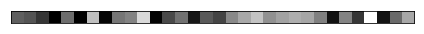

[[ 0.08213972  0.10358047  0.16152269  0.26017085  0.05615113  0.2616376
  -0.0961047   0.24950849  0.04031089  0.01435641 -0.14476268  0.25402448
   0.12153027  0.04820202  0.2176608   0.09161704  0.13301373  0.00452192
  -0.05414283 -0.10651875 -0.01084149 -0.04318497 -0.06520805 -0.04965849
   0.02117249  0.22585422  0.01365985  0.16028757 -0.21737503  0.22288351
   0.06512639 -0.0523538 ]]
32

Displaying Data 2,0


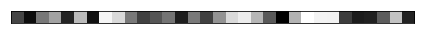

[[ 0.11487941  0.22345319  0.01611956 -0.06693721  0.1801707  -0.11361776
   0.21387176 -0.2294673  -0.17535812  0.01259922  0.1207541   0.08424877
   0.02264839  0.19109139  0.01113327  0.12318033 -0.03848087 -0.17393591
  -0.21120596 -0.10582683  0.07295809  0.25081626 -0.09973877 -0.24966621
  -0.22579148 -0.22369248  0.13129386  0.19607492  0.18645515  0.07052816
  -0.13008508  0.18098214]]
32

Displaying Data 2,1


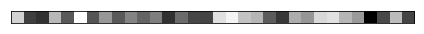

[[-0.15771845  0.17579122  0.20422257 -0.09941082  0.11341772 -0.26162741
   0.12553956 -0.02390798  0.11352034  0.01876803  0.09105571  0.03290129
   0.205011    0.07589758  0.1599301   0.16313349 -0.19119991 -0.23660679
  -0.12355996 -0.0959474   0.10869844  0.18944485 -0.07164571 -0.0224278
  -0.17154223 -0.19200219 -0.09591369 -0.03104099  0.31863201  0.1514799
  -0.10937496  0.16371247]]
32

Displaying Data 2,2


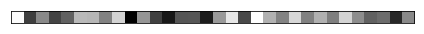

[[-0.1874204   0.16579565  0.02647104  0.15577245  0.10091379 -0.06281883
  -0.05678574  0.03989075 -0.11036387  0.28253925  0.00439858  0.16196012
   0.2361401   0.12424254  0.12176407  0.23029594 -0.00332801 -0.14524773
   0.14490771 -0.19342399 -0.04746502  0.03554914 -0.1160732   0.04193531
  -0.04576079  0.04569528 -0.11038802  0.01954591  0.10185152  0.08135843
   0.20806269  0.02640226]]


In [234]:
plot_filters(model.layers[0])
# plot_filters(model.layers[0],1)
# plot_filters(model.layers[0],2)
